In [1]:
!pip install sqlalchemy
!pip install pyodbc
from sqlalchemy import create_engine, select, Table, inspect, MetaData
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np

'''Denna delen av koden är direkt kopierad från kursmatrialet SQLAlchemy
    för att skapa en uppkoppling och ansluta till databasen.'''

def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

# For Windows authentication
# Replace the server argument with the Server Name found when logging into SQL Server Management Studio 
# OR
# For SQL Server authentication
# Replace the server, user and password argument with the Server Name, username and password
engine = new_engine('mssql', 'DESKTOP-A4R3AQR', 'AdventureWorks2022', integrated_security=True)

connection = engine.connect()


print(type(engine))
print(type(connection))


mssql://DESKTOP-A4R3AQR/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server
<class 'sqlalchemy.engine.base.Engine'>
<class 'sqlalchemy.engine.base.Connection'>


In [2]:
'''Skapar en dataframe för att visualisera antal män och kvinnor samt deras totala sjuktimmar.'''

df = pd.read_sql(sql = """
SELECT 
	Gender,
	COUNT(*) as Employees,
	SUM(SickLeaveHours) as TotalSickLeaveHours
FROM HumanResources.Employee
GROUP BY Gender;
""", con=connection)
df.head()

,Gender,Employees,TotalSickLeaveHours
0,F,84,3844
1,M,206,9295


In [3]:
'''skapar en dataframe för specifikt kvinnor'''

f_df = pd.read_sql(sql = """
SELECT
	BusinessEntityID,
	Gender,
	SUM(SickLeaveHours) as TotalSickLeaveHours
FROM HumanResources.Employee
GROUP BY BusinessEntityID, Gender
HAVING Gender = 'F';""", con=connection)

f_df.head()

,BusinessEntityID,Gender,TotalSickLeaveHours
0,2,F,20
1,5,F,22
2,8,F,51
3,9,F,51
4,13,F,24


In [4]:
'''skapar en dataframe specifikt för män.'''


m_df = pd.read_sql(sql = """
SELECT
	BusinessEntityID,
	Gender,
	SUM(SickLeaveHours) as TotalSickLeaveHours
FROM HumanResources.Employee
GROUP BY BusinessEntityID, Gender
HAVING Gender = 'M';""", con=connection)
m_df.head()

,BusinessEntityID,Gender,TotalSickLeaveHours
0,1,M,69
1,3,M,21
2,4,M,80
3,6,M,23
4,7,M,50


In [5]:
'''Skapar en samlad dataframe för män och kvinnor för att kunna räkna ut
    minsta sjuktimmarna, högsta sjuktimmarna, standardavvikelsen, medelvärdet,
    samt differansen mellan högsta och minsta sjuktimmarna.
'''

hr_data = pd.read_sql(sql="""SELECT
	Gender,
	COUNT(*) as Employees,
	MIN(SickLeaveHours) as MIN,
	MAX(SickLeaveHours) as MAX,
    STDEV(SickLeaveHours) as STD,
	AVG(SickLeaveHours) as MEAN,
	SUM(SickLeaveHours) as TOTAL
FROM HumanResources.Employee
GROUP BY Gender
ORDER BY TOTAL;""", con=connection)
hr_data["DIFF"] = hr_data["MAX"] - hr_data["MIN"]
hr_data.head()

,Gender,Employees,MIN,MAX,STD,MEAN,TOTAL,DIFF
0,F,84,20,69,15.104949,45,3844,49
1,M,206,20,80,14.337392,45,9295,60


In [13]:
#kontroll beräkning av Medelvärdet
print("Kvinnors medelvärde: ", 3844 / 84)
print("Mäns Medelvärde: ", 9295 / 206)

print("Här ser vi att det är en decimal skillnad på cirka 0.6")

Kvinnors medelvärde:  45.76190476190476
Mäns Medelvärde:  45.12135922330097
Här ser vi att det är en decimal skillnad på cirka 0.6


In [15]:
#Beräkning av Konfidensintervallen med en 95% konfidensnivå


#medelvärdet
mean1 = 45.76
mean2 = 45.12

#antal observationer i varje stickprov
n1 = 84
n2 = 206

#standardavvikelsen
std1 = 15.10
std2 = 14.33

#beräkning av standardfel för medelvärderna
sf1 = std1 / np.sqrt(n1)
sf2 = std2 / np.sqrt(n2)

#beräkning av z-värdet då vi har stora stickprov
z_value = stats.norm.ppf(0.975)

#beräknar konfidensintervallen för medelvärdena
ci_low = (mean1 - mean2) - z_value * np.sqrt((std1**2/n1) + (std2**2/n2))
ci_high = (mean1 - mean2) + z_value * np.sqrt((std1**2/n1) + (std2**2/n2))

print(f"Konfidensintervall: ({ci_low}, {ci_high})")
print("-3.1357901577913125 ", "< mean1 - mean2 < ", "4.415790157791314")
print("""Av dessa beräkningar kan vi dra slutsatsen att det finns en skillnad mellan Kvinnor och män,
men vi kan inte säkerställa att det alltid finns en skillnad mellan dem då Nollan finns med..""")


Konfidensintervall: (-3.1357901577913125, 4.415790157791314)
-3.1357901577913125  < mean1 - mean2 <  4.415790157791314
Av dessa beräkningar kan vi dra slutsatsen att det finns en skillnad mellan Kvinnor och män,
men vi kan inte säkerställa att det alltid finns en skillnad mellan dem då Nollan finns med..


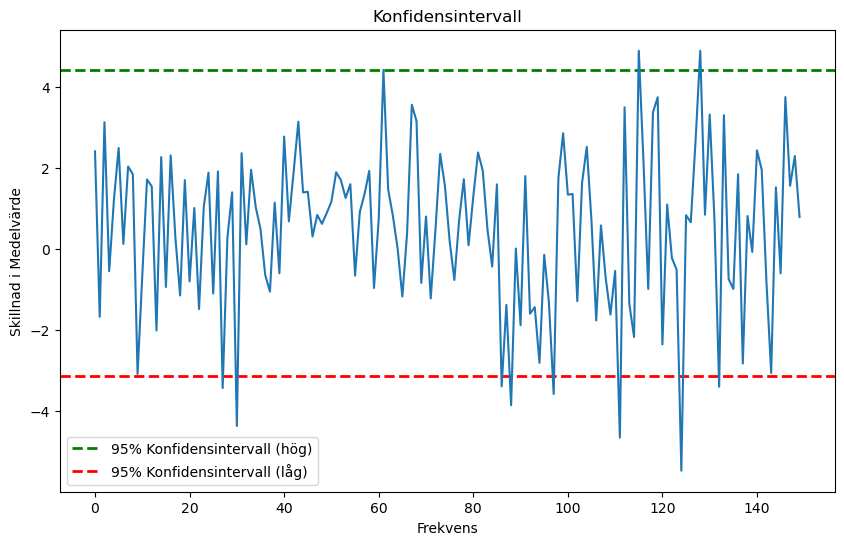

In [11]:
# make data
x1 = np.random.normal(loc=(mean1 - mean2), scale=np.sqrt((std1**2/n1) + (std2**2/n2)), size=150) 


plt.figure(figsize=(10, 6))

plt.axhline(ci_high, color='green', linestyle='dashed', linewidth=2, label='95% Konfidensintervall (hög)')
plt.axhline(ci_low, color='red', linestyle='dashed', linewidth=2, label='95% Konfidensintervall (låg)')



plt.plot(x1)
plt.title('Konfidensintervall')
plt.xlabel('Frekvens')
plt.ylabel('Skillnad i Medelvärde')

plt.legend()
plt.show()